*GOALS*:
- extract the main features of the model (feature importance).
- make a data drift report.

**Table of contents**<a id='toc0_'></a>    
- 1. [Load the production model](#toc1_)    
- 2. [Load the data used for training and testing](#toc2_)    
- 3. [Extract main features](#toc3_)    
  - 3.1. [From the model itself](#toc3_1_)    
  - 3.2. [Using shap](#toc3_2_)    
  - 3.3. [Second shap evaluation](#toc3_3_)    
- 4. [Data drift on main features](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
# Append path to find my_scorers and config
sys.path.append('..')
from project_tools import utils
from api import api_utils

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Load the production model

In [3]:
# Variables
MLFLOW_TRACKING_URI = "/home/louberehc/OCR/projets/7_scoring_model/mlruns"
model_name = "lightgbm_280000"
stage = "Production"
version = 1

# Set the Mlflow tracking URI
api_utils.set_mlflow_tracking_URI(MLFLOW_TRACKING_URI)
# get the model run id
model_run_id = (
    api_utils
    .get_model_run_id_from_name_stage_version(model_name, stage, version)
)
# Build a valid model uri from it
model_uri = api_utils.make_model_uri(model_run_id)
# Load the model from the model registry
model = api_utils.load_model(model_uri)
# Get model threshold
model_threshold = api_utils.get_model_threshold(model_run_id)

In [4]:
model

LGBMClassifier(colsample_bytree=0.7886281999030231, data_sample_strategy='goss',
               is_unbalance=False, learning_rate=0.01752285342870759,
               max_depth=14, min_child_samples=230,
               min_split_gain=0.0402532222541853, n_estimators=10000,
               nthread=-1, num_leaves=54, objective='binary', random_state=103,
               reg_alpha=0.8631398118506094, reg_lambda=0.5957468159776326,
               subsample=0.8679759773737233, subsample_for_bin=140000,
               verbosity=1)

In [4]:
model.best_iteration_

920

In [5]:
model.feature_importances_.shape

(735,)

# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Load the data used for training and testing

In [5]:
DATA_PATH = '../pickle_files/features.pkl.gz'
n_sample = 280_000

# utils.load_split_clip_scale_and_impute() parameters.
pre_processing_params = dict(
        predictors=None, 
        n_sample=n_sample,
        ohe=False,
        clip=False,
        scaling_method=None,
        imputation_method=None,
)

# Load the data
print('>>>>>> Load and pre-process raw features <<<<<<\n')
(
    X_train_pp, X_test_pp, y_train, y_test, pre_processors,
    
) = utils.load_split_clip_scale_and_impute_data(
    DATA_PATH,
    **pre_processing_params
)

# List of categorical features
categorical_features = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE',
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START'
]


>>>>>> Load and pre-process raw features <<<<<<

>>> Read the pickle file
It took 6.706s
>>> Filtering individual with more than 400 null values
before : 307506
after : 286952
>>> Feature selection :   Data shape: (286952, 735), target shape: (286952,)
>>> Sampling with a fixed random state : 280000 random samples.
Train shapes : (224000, 735), (224000,)
Test shapes : (56000, 735), (56000,)
>>> Imputing categorical features
>>> No Scaling
>>> No imputation


# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Extract main features

In [6]:
n_fts = 20

## 3.1.  [&#9650;](#toc0_) <a id='toc3_1_'></a>From the model itself

In [7]:
fi = model.feature_importances_
top_idx = fi.argsort()[-n_fts:][::-1]
top_fts_lgbm = list(X_train_pp.columns[top_idx])
top_fts_lgbm

['ORGANIZATION_TYPE',
 'OCCUPATION_TYPE',
 'CREDIT_TO_ANNUITY_RATIO',
 'EXT_SOURCES_MEAN',
 'DAYS_BIRTH',
 'EXT_SOURCE_3',
 'CREDIT_TO_GOODS_RATIO',
 'EXT_SOURCES_NANMEDIAN',
 'AMT_ANNUITY',
 'EXT_SOURCE_1',
 'ANNUITY_TO_INCOME_RATIO',
 'EXT_SOURCES_MIN',
 'EXT_SOURCE_2',
 'DAYS_ID_PUBLISH',
 'PREV_DAYS_TERMINATION_MAX',
 'BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN',
 'CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO',
 'DAYS_REGISTRATION',
 'DAYS_LAST_PHONE_CHANGE',
 'EXT_SOURCES_MAX']

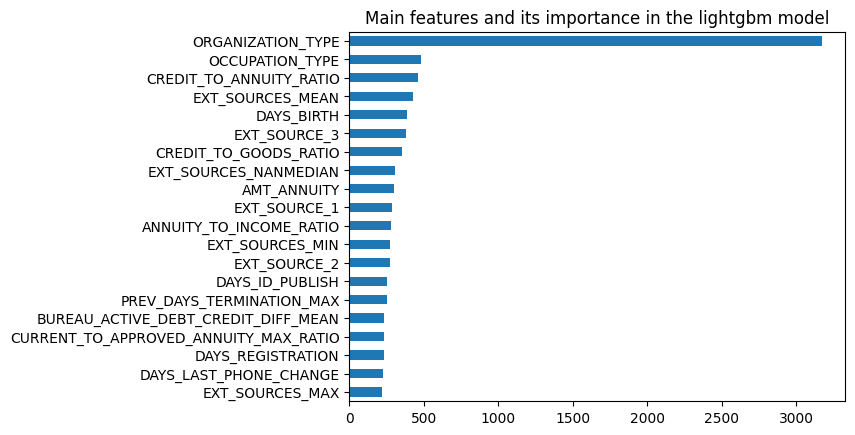

In [8]:
fts_lgbm = pd.Series(fi[top_idx], index=top_fts_lgbm).sort_values()
fts_lgbm.plot(
    kind='barh',
    title='Main features and its importance in the lightgbm model'
)
plt.show()

## 3.2.  [&#9650;](#toc0_) <a id='toc3_2_'></a>Using shap

In [9]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [10]:
explainer = shap.TreeExplainer(model, num_iteration=model.best_iteration_)

In [11]:
# shap values explainer with 3 fiels (values, base_values, data)
# Need to sample for time purpose. 10_000 -> already ~2min
sv = explainer(X_train_pp.sample(10_000))
# Shap values 
shap_values_pos_class = sv.values[:, :, 1]

In [12]:
# mean contribution of the abs shap values per feature
vals = np.abs(shap_values_pos_class).mean(0)

In [13]:
feature_importance = pd.DataFrame(list(zip(X_train_pp.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance = feature_importance.set_index('col_name').sort_values('feature_importance_vals', ascending=False)
feature_importance.head(n_fts)

,feature_importance_vals
col_name,
EXT_SOURCES_MEAN,0.366750
CODE_GENDER,0.098808
CREDIT_TO_GOODS_RATIO,0.090679
ORGANIZATION_TYPE,0.084314
AMT_ANNUITY,0.068799
NAME_FAMILY_STATUS,0.063765
EXT_SOURCES_NANMEDIAN,0.056930
GROUP2_EXT_SOURCES_MEDIAN,0.053270
CREDIT_TO_ANNUITY_RATIO,0.047613


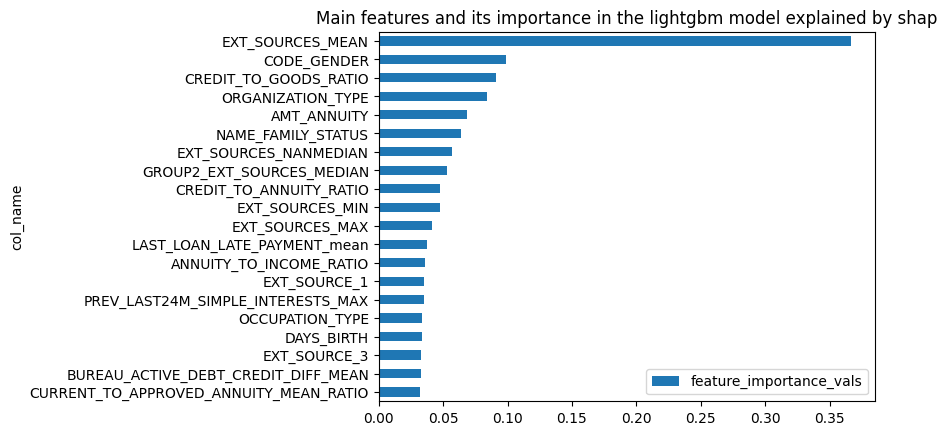

In [14]:
feature_importance.head(n_fts).sort_values('feature_importance_vals').plot(
    kind='barh',
    title='Main features and its importance in the lightgbm model explained by shap'
)
plt.show()

In [15]:
top_fts_shap = feature_importance.index[:n_fts]
top_fts_shap

Index(['EXT_SOURCES_MEAN', 'CODE_GENDER', 'CREDIT_TO_GOODS_RATIO',
       'ORGANIZATION_TYPE', 'AMT_ANNUITY', 'NAME_FAMILY_STATUS',
       'EXT_SOURCES_NANMEDIAN', 'GROUP2_EXT_SOURCES_MEDIAN',
       'CREDIT_TO_ANNUITY_RATIO', 'EXT_SOURCES_MIN', 'EXT_SOURCES_MAX',
       'LAST_LOAN_LATE_PAYMENT_mean', 'ANNUITY_TO_INCOME_RATIO',
       'EXT_SOURCE_1', 'PREV_LAST24M_SIMPLE_INTERESTS_MAX', 'OCCUPATION_TYPE',
       'DAYS_BIRTH', 'EXT_SOURCE_3', 'BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN',
       'CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'],
      dtype='object', name='col_name')

In [16]:
# Common top features
inter = set(top_fts_lgbm).intersection(set(top_fts_shap))
common_fts = list(inter)
common_fts


['EXT_SOURCES_MAX',
 'AMT_ANNUITY',
 'CREDIT_TO_GOODS_RATIO',
 'EXT_SOURCES_NANMEDIAN',
 'BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN',
 'OCCUPATION_TYPE',
 'CREDIT_TO_ANNUITY_RATIO',
 'EXT_SOURCES_MIN',
 'DAYS_BIRTH',
 'ANNUITY_TO_INCOME_RATIO',
 'EXT_SOURCES_MEAN',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1']

In [17]:
len(inter)

14

In [18]:
# Values in lgbm fi but not according shap top 20
for ft in top_fts_lgbm:
    if ft not in top_fts_shap:
        print(ft)

EXT_SOURCE_2
DAYS_ID_PUBLISH
PREV_DAYS_TERMINATION_MAX
CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO
DAYS_REGISTRATION
DAYS_LAST_PHONE_CHANGE


In [19]:
# and vice-versa
for ft in top_fts_shap:
    if ft not in top_fts_lgbm:
        print(ft)

CODE_GENDER
NAME_FAMILY_STATUS
GROUP2_EXT_SOURCES_MEDIAN
LAST_LOAN_LATE_PAYMENT_mean
PREV_LAST24M_SIMPLE_INTERESTS_MAX
CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO


In [20]:
fts_union = list(set(top_fts_lgbm).union(set(top_fts_shap)))
fts_union

['EXT_SOURCES_MAX',
 'OCCUPATION_TYPE',
 'DAYS_LAST_PHONE_CHANGE',
 'NAME_FAMILY_STATUS',
 'PREV_LAST24M_SIMPLE_INTERESTS_MAX',
 'EXT_SOURCES_NANMEDIAN',
 'BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN',
 'DAYS_BIRTH',
 'ANNUITY_TO_INCOME_RATIO',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_3',
 'CREDIT_TO_GOODS_RATIO',
 'EXT_SOURCE_2',
 'EXT_SOURCES_MIN',
 'GROUP2_EXT_SOURCES_MEDIAN',
 'LAST_LOAN_LATE_PAYMENT_mean',
 'CODE_GENDER',
 'AMT_ANNUITY',
 'DAYS_ID_PUBLISH',
 'CREDIT_TO_ANNUITY_RATIO',
 'DAYS_REGISTRATION',
 'CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO',
 'EXT_SOURCES_MEAN',
 'PREV_DAYS_TERMINATION_MAX',
 'CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO',
 'EXT_SOURCE_1']

## 3.3.  [&#9650;](#toc0_) <a id='toc3_3_'></a>Second shap evaluation

In [22]:
explainer = shap.TreeExplainer(model, num_iteration=model.best_iteration_)

In [23]:
# shap values explainer with 3 fiels (values, base_values, data)
# Need to sample for time purpose. 10_000 -> already ~2min
sv = explainer(X_train_pp.sample(10_000))
# Shap values 
shap_values_pos_class = sv.values[:, :, 1]

In [24]:
# mean contribution of the abs shap values per feature
vals = np.abs(shap_values_pos_class).mean(0)

In [25]:
feature_importance = pd.DataFrame(list(zip(X_train_pp.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance = feature_importance.set_index('col_name').sort_values('feature_importance_vals', ascending=False)
feature_importance.head(n_fts)

,feature_importance_vals
col_name,
EXT_SOURCES_MEAN,0.369016
CODE_GENDER,0.098319
CREDIT_TO_GOODS_RATIO,0.090527
ORGANIZATION_TYPE,0.082724
AMT_ANNUITY,0.069138
NAME_FAMILY_STATUS,0.064216
EXT_SOURCES_NANMEDIAN,0.057764
GROUP2_EXT_SOURCES_MEDIAN,0.052670
CREDIT_TO_ANNUITY_RATIO,0.047648


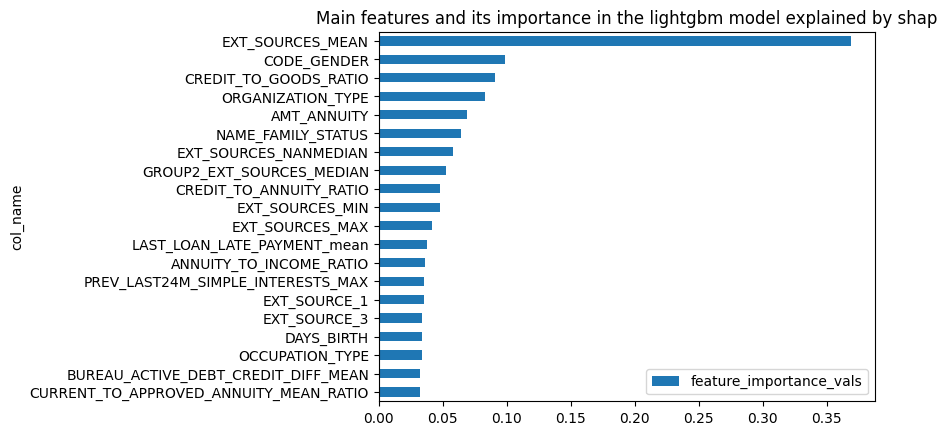

In [26]:
feature_importance.head(n_fts).sort_values('feature_importance_vals').plot(
    kind='barh',
    title='Main features and its importance in the lightgbm model explained by shap'
)
plt.show()

We see a very slight variation in mean abs shap values but the ranking is almost preserved.

I am going to draw a report on the union features fts_union.

# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>Data drift on main features

In [38]:
try:
    import evidently
except:
    !pip install git+https://github.com/evidentlyai/evidently.git

In [21]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset
from evidently.pipeline.column_mapping import ColumnMapping

In [22]:
# column mapping
sel_cat_fts = [ft for ft in fts_union if ft in categorical_features]
sel_num_fts = [ft for ft in fts_union if ft not in sel_cat_fts]

column_mapping = ColumnMapping()
column_mapping.categorical_features = sel_cat_fts
column_mapping.numerical_features = sel_num_fts
column_mapping.id = "SK_ID_CURR"
column_mapping.datetime = None
display(column_mapping)

ColumnMapping(target='target', prediction='prediction', datetime=None, id='SK_ID_CURR', numerical_features=['EXT_SOURCES_MAX', 'DAYS_LAST_PHONE_CHANGE', 'PREV_LAST24M_SIMPLE_INTERESTS_MAX', 'EXT_SOURCES_NANMEDIAN', 'BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN', 'DAYS_BIRTH', 'ANNUITY_TO_INCOME_RATIO', 'EXT_SOURCE_3', 'CREDIT_TO_GOODS_RATIO', 'EXT_SOURCE_2', 'EXT_SOURCES_MIN', 'GROUP2_EXT_SOURCES_MEDIAN', 'LAST_LOAN_LATE_PAYMENT_mean', 'AMT_ANNUITY', 'DAYS_ID_PUBLISH', 'CREDIT_TO_ANNUITY_RATIO', 'DAYS_REGISTRATION', 'CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO', 'EXT_SOURCES_MEAN', 'PREV_DAYS_TERMINATION_MAX', 'CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO', 'EXT_SOURCE_1'], categorical_features=['OCCUPATION_TYPE', 'NAME_FAMILY_STATUS', 'ORGANIZATION_TYPE', 'CODE_GENDER'], datetime_features=None, target_names=None, task=None, pos_label=1, text_features=None, embeddings=None)

In [28]:
# prepare both sets
ref_data = X_train_pp.loc[:, fts_union]
ref_data['target'] = y_train
current_data = X_test_pp.loc[:, fts_union]
current_data['target'] = y_test
display(ref_data.head())
display(current_data.head())

,EXT_SOURCES_MAX,OCCUPATION_TYPE,DAYS_LAST_PHONE_CHANGE,NAME_FAMILY_STATUS,PREV_LAST24M_SIMPLE_INTERESTS_MAX,EXT_SOURCES_NANMEDIAN,BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN,DAYS_BIRTH,ANNUITY_TO_INCOME_RATIO,ORGANIZATION_TYPE,...,AMT_ANNUITY,DAYS_ID_PUBLISH,CREDIT_TO_ANNUITY_RATIO,DAYS_REGISTRATION,CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO,EXT_SOURCES_MEAN,PREV_DAYS_TERMINATION_MAX,CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO,EXT_SOURCE_1,target
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
271316,0.656250,15,-1055.0,1,0.019187,0.638184,126355.500000,-18244,0.331787,9,...,52240.5,-1799,25.156250,-2444.0,0.214038,0.638184,-263.0,0.153470,NaN,0.0
105589,0.294189,5,-222.0,0,0.027780,0.080811,3154.949951,-8361,0.149292,23,...,20146.5,-980,18.312500,-2360.0,0.307952,0.135010,-194.0,0.297054,0.080811,0.0
167893,0.774902,6,-1807.0,4,NaN,0.771484,NaN,-17137,0.192627,31,...,13005.0,-690,27.562500,-9584.0,0.692042,0.612793,NaN,0.692042,0.774902,0.0
211164,0.431152,0,-3.0,1,NaN,0.263184,55041.000000,-13623,0.144287,0,...,19480.5,-5668,20.421875,-7168.0,0.261975,0.263184,-1390.0,0.261975,NaN,0.0
283545,0.620117,6,-1207.0,2,0.020770,0.549805,188293.500000,-16154,0.195923,12,...,29970.0,-4008,21.359375,-9920.0,0.481389,0.549805,-1071.0,0.321469,NaN,0.0


,EXT_SOURCES_MAX,OCCUPATION_TYPE,DAYS_LAST_PHONE_CHANGE,NAME_FAMILY_STATUS,PREV_LAST24M_SIMPLE_INTERESTS_MAX,EXT_SOURCES_NANMEDIAN,BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN,DAYS_BIRTH,ANNUITY_TO_INCOME_RATIO,ORGANIZATION_TYPE,...,AMT_ANNUITY,DAYS_ID_PUBLISH,CREDIT_TO_ANNUITY_RATIO,DAYS_REGISTRATION,CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO,EXT_SOURCES_MEAN,PREV_DAYS_TERMINATION_MAX,CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO,EXT_SOURCE_1,target
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
432586,0.277832,0,NaN,4,NaN,0.220825,57201.660156,-15840,0.193115,11,...,33021.0,-4241,17.843750,-4260.0,0.155455,0.220825,-1452.0,0.121748,NaN,1.0
429656,0.599121,1,-862.0,1,0.019513,0.434326,NaN,-18044,0.083313,28,...,11245.5,-1597,17.703125,-2866.0,1.972025,0.434326,-404.0,0.834801,NaN,0.0
100201,0.765137,1,-1754.0,0,0.010833,0.601562,118281.375000,-12147,0.204102,23,...,36747.0,-1719,18.375000,-6188.0,0.330734,0.572266,-601.0,0.201112,0.765137,0.0
366026,0.517090,12,-535.0,1,0.039872,0.308105,35370.000000,-13379,0.224854,0,...,30357.0,-1361,8.390625,-1378.0,1.589168,0.335938,-172.0,1.589168,0.308105,1.0
378834,0.652832,0,-1653.0,2,0.024367,0.642090,277326.000000,-18204,0.149292,0,...,20151.0,-1741,10.109375,-10760.0,0.769149,0.642090,-104.0,0.461398,NaN,0.0


In [60]:
drift_report = Report(
    metrics=[
        DataDriftPreset(),
    #    TargetDriftPreset(),
    ]
)
 
drift_report.run(
    reference_data=ref_data.sample(10_000),
    current_data=current_data.sample(5_000),
    column_mapping=column_mapping
)
drift_report

KeyError: 'index'

In [63]:
# EXPERIMENT TO FIND A BUG?
for column_name in sel_num_fts[:2]:
    a = ref_data[column_name]#.reset_index().sort_values("index")
    break

In [64]:
a.head()

SK_ID_CURR
271316    0.638184
105589    0.135010
167893    0.612793
211164    0.263184
283545    0.549805
Name: EXT_SOURCES_MEAN, dtype: float16

In [65]:
a.reset_index()

,SK_ID_CURR,EXT_SOURCES_MEAN
0,271316,0.638184
1,105589,0.135010
2,167893,0.612793
3,211164,0.263184
4,283545,0.549805
...,...,...
223995,126573,0.652344
223996,177290,0.289551
223997,433582,0.536133
223998,150410,0.588867


As my index has a name, when resetting index, it can not sort by index which does not exist.

Let's rename the index of both dataset:

In [29]:
ref_data.reset_index(names=['index'])#.sort_values('index')

,index,EXT_SOURCES_MAX,OCCUPATION_TYPE,DAYS_LAST_PHONE_CHANGE,NAME_FAMILY_STATUS,PREV_LAST24M_SIMPLE_INTERESTS_MAX,EXT_SOURCES_NANMEDIAN,BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN,DAYS_BIRTH,ANNUITY_TO_INCOME_RATIO,...,AMT_ANNUITY,DAYS_ID_PUBLISH,CREDIT_TO_ANNUITY_RATIO,DAYS_REGISTRATION,CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO,EXT_SOURCES_MEAN,PREV_DAYS_TERMINATION_MAX,CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO,EXT_SOURCE_1,target
0,271316,0.656250,15,-1055.0,1,0.019187,0.638184,126355.500000,-18244,0.331787,...,52240.5,-1799,25.156250,-2444.0,0.214038,0.638184,-263.0,0.153470,NaN,0.0
1,105589,0.294189,5,-222.0,0,0.027780,0.080811,3154.949951,-8361,0.149292,...,20146.5,-980,18.312500,-2360.0,0.307952,0.135010,-194.0,0.297054,0.080811,0.0
2,167893,0.774902,6,-1807.0,4,NaN,0.771484,NaN,-17137,0.192627,...,13005.0,-690,27.562500,-9584.0,0.692042,0.612793,NaN,0.692042,0.774902,0.0
3,211164,0.431152,0,-3.0,1,NaN,0.263184,55041.000000,-13623,0.144287,...,19480.5,-5668,20.421875,-7168.0,0.261975,0.263184,-1390.0,0.261975,NaN,0.0
4,283545,0.620117,6,-1207.0,2,0.020770,0.549805,188293.500000,-16154,0.195923,...,29970.0,-4008,21.359375,-9920.0,0.481389,0.549805,-1071.0,0.321469,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223995,126573,0.691895,-1,-1673.0,1,NaN,0.651855,279000.000000,-13025,0.453613,...,51025.5,-4913,10.085938,-3364.0,0.683305,0.652344,-894.0,0.396201,0.651855,0.0
223996,177290,0.430664,5,-1264.0,4,NaN,0.355713,0.000000,-15117,0.168213,...,14377.5,-5481,15.648438,-5480.0,0.690701,0.289551,-284.0,0.481897,0.082581,1.0
223997,433582,0.705566,1,-1514.0,1,NaN,0.583008,243612.984375,-11546,0.116577,...,44586.0,-3592,34.093750,-5288.0,0.515012,0.536133,-880.0,0.355157,0.319092,0.0
223998,150410,0.697266,-1,-591.0,1,0.019187,0.588867,10062.000000,-22080,0.204956,...,24907.5,-4426,22.578125,-1554.0,0.160958,0.588867,-222.0,0.160958,NaN,1.0


In [67]:
ref_data.index.names = ['index']
current_data.index.names = ['index']

In [75]:
drift_report = Report(
    metrics=[
        DataDriftPreset(),
    #    TargetDriftPreset(),
    ]
)
 
drift_report.run(
    reference_data=ref_data.sample(30_000),
    current_data=current_data.sample(10_000),
    column_mapping=column_mapping
)


/home/louberehc/.pyenv/versions/3.11.4/envs/p7/lib/python3.11/site-packages/numpy/core/_methods.py:215: RuntimeWarning:

overflow encountered in reduce

/home/louberehc/.pyenv/versions/3.11.4/envs/p7/lib/python3.11/site-packages/evidently/calculations/data_drift.py:229: RuntimeWarning:

invalid value encountered in scalar add

/home/louberehc/.pyenv/versions/3.11.4/envs/p7/lib/python3.11/site-packages/numpy/core/_methods.py:215: RuntimeWarning:

overflow encountered in reduce

/home/louberehc/.pyenv/versions/3.11.4/envs/p7/lib/python3.11/site-packages/evidently/calculations/data_drift.py:229: RuntimeWarning:

invalid value encountered in scalar add

/home/louberehc/.pyenv/versions/3.11.4/envs/p7/lib/python3.11/site-packages/numpy/core/_methods.py:215: RuntimeWarning:

overflow encountered in reduce

/home/louberehc/.pyenv/versions/3.11.4/envs/p7/lib/python3.11/site-packages/evidently/calculations/data_drift.py:229: RuntimeWarning:

invalid value encountered in scalar add

/home/loubere

In [76]:
drift_report.save_html('./data_drift_report.html')